In [1]:
from __future__ import print_function

import sys
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm


import copy

import numpy as np
import torch

from common.hvsmr.config import config_hvsmr
from in_out.hvsmr.load_data import HVSMR2016DataSet
from plotting.color_maps import transparent_cmap
from utils.hvsmr.batch_handler import HVSMRTwoDimBatchHandler
from utils.hvsmr.experiment import HVSMRExperiment as Experiment
from utils.hvsmr.exper_handler import HVSMRExperimentHandler as ExperimentHandler
from utils.hvsmr.test_handler import HVSMRTesthandler as TestHandler

from utils.hvsmr.selective_classification import SelectiveClassification

mycmap = transparent_cmap(plt.get_cmap('jet'))
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs/HVSMR")

FOLD_ID = 0

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Step 0 - Load the experiment handlers for all models and folds

Based on the *FOLD_ID* variable the procedure *get_experiment_handlers* will load all experiments that we have specified in the experiment dictionaries (the exper-ID e.g. **20180919_23_03_53_dcnn_hvsmr_mc_f0p01_brier_10KE_lr1e03** is specified in the same procedure).

In [2]:
from utils.hvsmr.exper_hdl_ensemble import get_experiment_handlers    

exper_ensemble_brier, exper_ensemble_entropy, exper_ensemble_softdice = get_experiment_handlers()
exper_hdl_mc_brier = exper_ensemble_brier.seg_exper_handlers[FOLD_ID]
exper_hdl_mc_entropy = exper_ensemble_entropy.seg_exper_handlers[FOLD_ID]
exper_hdl_mc_softdice = exper_ensemble_softdice.seg_exper_handlers[FOLD_ID]
print("Model name: {}".format(exper_hdl_mc_brier.model_name))  
print("Model name: {}".format(exper_hdl_mc_entropy.model_name))
print("Model name: {}".format(exper_hdl_mc_softdice.model_name))
print("-------------------------------------------------------------------------")



Load experiment from /home/jorg/repository/dcnn_acdc/logs/HVSMR/20180919_23_03_53_dcnn_hvsmr_mc_f0p01_brier_10KE_lr1e03/stats/exper_stats.dll
Load experiment from /home/jorg/repository/dcnn_acdc/logs/HVSMR/20180920_17_04_37_dcnn_hvsmr_mc_f0p01_entrpy_10KE_lr5e04/stats/exper_stats.dll
Load experiment from /home/jorg/repository/dcnn_acdc/logs/HVSMR/20180921_08_52_02_dcnn_hvsmr_mc_f0p01_sdice_8KE_r_lr5e04/stats/exper_stats.dll
Model name: dcnn_hvsmr_mc p=0.10 fold=0 loss=brier
Model name: dcnn_hvsmr_mc p=0.10 fold=0 loss=cross-entropy
Model name: dcnn_hvsmr_mc p=0.10 fold=0 loss=soft-dice
-------------------------------------------------------------------------


## Step 1 - Test model on hold-out patients

Evaluate each model on the hold-out patients. Generate the the following objects:

    (1) probability maps and segmentation masks with ONE forward pass
    (2) Entropy maps (per slice)
    (3) Using MC-dropout (T=10) generate probability maps and segmentation masks (using mean-softmax response). This will also store the raw *Bayesian* uncertainty map that we'll use to generate the aggregate u-maps (mean/max)
    (4) Bayesian (aggregate) uncertainty map (we currently only use *mean* because the *max* seem to deliver the same result)
    
   The objects are stored in the experiment directory under *pred_labels* and *u_maps*.

In [47]:
exper_handler = exper_hdl_mc_entropy

exper_handler.test_set = None
patient_id = "patient009"
checkpoint = exper_handler.exper.epoch_id
print("Checkpoint {} - Patient_id {}".format(checkpoint, patient_id))

# WITHOUT MC-dropout, in order to create entropy maps
exper_handler.test(checkpoint, patient_id, mc_samples=1, sample_weights=False, 
                          compute_hd=False, store_details=False, do_filter=True, save_pred_labels=True,
                          store_test_results=False, save_umaps=True)
_ = exper_handler.create_entropy_maps(patient_id=patient_id, do_save=True)
# WITH MC-dropout, in order to create Bayesian u-maps
exper_handler.test(checkpoint, patient_id, mc_samples=10, sample_weights=True, 
                          compute_hd=False, store_details=False, do_filter=True, save_pred_labels=True,
                          store_test_results=False, save_umaps=True)
exper_handler.create_agg_bayes_umap(patient_id=patient_id, aggregate_func="mean")

 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]

Checkpoint 10000 - Patient_id patient009


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Image 1-patient009 - test loss 0.000  dice(RV/Myo/LV):	 0.76/0.91	
INFO - Saved all entropy maps to /home/jorg/repository/dcnn_acdc/logs/HVSMR/20180920_17_04_37_dcnn_hvsmr_mc_f0p01_entrpy_10KE_lr5e04/u_maps
Image 1-patient009 - test loss 0.000  dice(RV/Myo/LV):	 0.74/0.91	


## Step 2 - Run selective classification for an ensemble of handlers for each uncertainty map

In order to be able to produce the coverage-risk plots, that enable us to compare the performance of the uncertainty maps, we are going to compute the coverage and risk for a couple of uncertainty thresholds. 
We're currently doing this for the Bayesian uncertainty maps (with aggregate function *mean*) and the entropy maps (emap). You can also run this although you haven't done all the evaluations of the folds. The result object will be stored in the <root>/data/HRMS/Folds directory.

In [6]:
exper_ensemble = exper_ensemble_softdice  # exper_ensemble_softdice

sel_cls_handler_umap_mean = SelectiveClassification(exper_ensemble, type_of_map="umap", 
                                                    aggregate_func="mean", force_reload=True,
                                                    do_save=True, num_of_thresholds=25)
sel_cls_handler_umap_mean()
print("Ready")

100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Patient patient009
Patient patient010
INFO - Saved results to /home/jorg/repository/dcnn_acdc/data/HVSMR/Folds/sel_pred_umap_umap_softdice.dll
Ready


In [7]:
sel_cls_handler = SelectiveClassification(exper_ensemble, type_of_map="emap", do_save=True, num_of_thresholds=25,
                                          force_reload=True)
sel_cls_handler()
print("Ready")

Patient patient009
Patient patient010
INFO - Saved results to /home/jorg/repository/dcnn_acdc/data/HVSMR/Folds/sel_pred_emap_softdice.dll
Ready


INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/figures/coverage_risk_curve_cross-entropy.jpeg


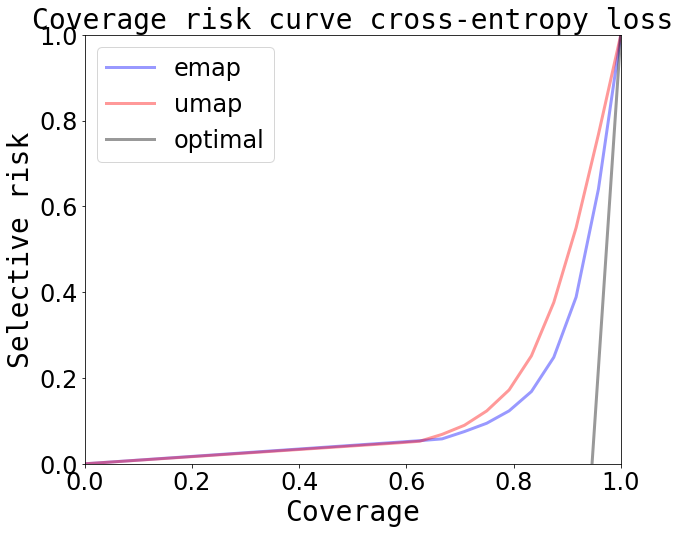

In [20]:
from plotting.coverage_risk import plot_coverage_risk_curve

sel_cls_handler_umap_mean = SelectiveClassification.load(exper_ensemble_entropy, type_of_map="umap",
                                                         aggregate_func="mean")
sel_cls_handler_emap = SelectiveClassification.load(exper_ensemble_entropy, type_of_map="emap",
                                                         aggregate_func=None)

plot_coverage_risk_curve([sel_cls_handler_emap, sel_cls_handler_umap_mean], width=10, height=8, 
                         do_save=True, do_show=True)

## Step 3 - Generate the data necessary to make the *calibration* plots

For each model (dcnn with different loss function) we generate the data that is needed to produce the calibration plots. We run this for each exper_dict. The result object is again stored in <root>/data/HRMS/Folds and can be loaded using the CalibrationData object (method load). 

**Note:** It should be possible to run the same method also for the ACDC dataset, using class_range=[1,2,3] and cardiac_phase=2. 

In [24]:
from plotting.hvsmr.calibration_plots import compute_calibration_terms

exper_dict = exper_ensemble_entropy.exper_dict

prob_bins, acc_bins, probs_per_bin = compute_calibration_terms(exper_dict, patient_id=None, mc_dropout=False, 
                                                               force_reload=False, num_of_bins=10,
                                                               do_save=True, class_range=[1, 2], 
                                                               cardiac_phases=1)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/HVSMR/20180920_17_04_37_dcnn_hvsmr_mc_f0p01_entrpy_10KE_lr5e04/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_hvsmr_mc p=0.10 fold=['0'] loss=cross-entropy


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


INFO - Successfully saved numpy arrays to location /home/jorg/repository/dcnn_acdc/data/HVSMR/Folds/calibration_dcnn_hvsmr_mc_crossentropy.npz


INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/figures/dcnn_hvsmr_mc_crossentropy_reliability_probs.jpeg


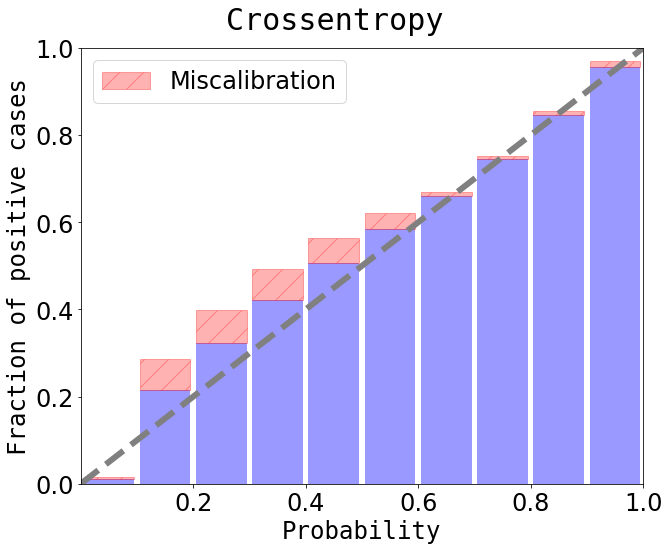

In [42]:
from plotting.hvsmr.calibration_plots import plot_reliability_diagram
from plotting.calibration_plots import CalibrationData

cal_data = CalibrationData(model_name="dcnn_hvsmr_mc", loss_function="crossentropy")
cal_data.load(env_config=config_hvsmr)

plot_reliability_diagram(cal_data, height=8, width=10, do_show=False, do_save=True,
                         phase_labels=[""])